### Fitbit Validation Analysis and Graphs
####Due November 20 2015 to Courtney

What I want to do:
- Import all data from actigraphs, azumio and fitbit
- Make graphs to compare all for each user
- With all data individually:
    Average steps over a 7 day period
- With actigraph data, get MVPA

Edit comments (spelling)
Change to hours

import ipdb; ipdb.set_trace()

In [123]:
import pandas as pd
import numpy as np
import os.path
import glob
import datetime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("ggplot")

In [124]:
# Creating a list of all accelerometer .csv files
accel_file = glob.glob("/Users/megan/Desktop/MIDS project/Accel CSV data/User*_ActigraphMay.csv")

# Creating a dataframe that stores user and date range information, setting user id as the index
dates = pd.read_csv('/Users/megan/Desktop/MIDS project/Dates.csv', index_col=0, parse_dates=['Initial', 'Final'])

# Defining a variable for minuties of moderate to vigorous physical activity threshold
mvpa_threshold = 1951


In [125]:
# Creating an empty data frame to store individual data frames from the following for loop
total = pd.DataFrame()

for file in accel_file:
    # Reading accelerometer file, changing time variable 
    accel = pd.read_csv(file, skipinitialspace=True, parse_dates=[['Date','Time']])
    accel['Date_Time'] = accel['Date_Time'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 0))
    
    # Storing the user ID from the file name
    user_id = int(os.path.basename(file).split("_")[0].replace('User',''))
    
    # Limiting dates to the days of the study
    date_range = dates.loc[user_id]
    date_bool1 = np.array(accel.Date_Time > date_range.Initial)
    date_bool2 = np.array(accel.Date_Time < date_range.Final)
    wear_dates = np.logical_and(date_bool1, date_bool2)
    accel = accel[wear_dates]
    
    # Boolean variable classifying each minute as MVPA or not
    accel['MVPA'] = accel['Axis1'] > mvpa_threshold
    
    # Grouping by hour and finding out total steps and MVPA per hour
    by_hour = accel.groupby(['Date_Time'])
    hour_totals = by_hour.sum().reset_index()
    hour_totals['User'] = user_id
    hour_totals['Type'] = 'Actigraph'
    
    # Appending the user dataframe to the total dataframe
    total = total.append(hour_totals, ignore_index=True)

accel_total = total[['User', 'Type', 'Date_Time', 'Steps', 'MVPA']]
accel_total.head()

,User,Type,Date_Time,Steps,MVPA
0,10311,Actigraph,2015-05-15 08:00:00,0,0
1,10311,Actigraph,2015-05-15 09:00:00,0,0
2,10311,Actigraph,2015-05-15 10:00:00,1,0
3,10311,Actigraph,2015-05-15 11:00:00,101,0
4,10311,Actigraph,2015-05-15 12:00:00,4,0


In [118]:
# Reading in fitbit data and editing columns to match the Actigraph data
fitbit = pd.read_csv('/Users/megan/Desktop/MIDS project/Fitbit .txt files/meas_fitbit_intraday_1wk_4.txt', sep='|', parse_dates=['date'])
fitbit.rename(columns={'user_id':'User', 'date':'Date', 'steps':'Steps'}, inplace=True)
fitbit.sort(['User','Date','minute'], axis=0, inplace=True)
fitbit['Hour'] = (fitbit['minute'] / 60).astype(int) % 24
fitbit.loc[fitbit['minute']==1440, 'Date'] += datetime.timedelta(days=1)
fitbit['Date_Time'] = fitbit[['Date', 'Hour']].apply(lambda row: datetime.datetime(row.Date.year, row.Date.month, row.Date.day, row.Hour, 0), axis=1)


# Dropping dates outside of the date range for each user
fitbit = fitbit.join(dates, on='User')
date_bool1 = np.array(fitbit.Date_Time > fitbit.Initial)
date_bool2 = np.array(fitbit.Date_Time < fitbit.Final)
wear_dates = np.logical_and(date_bool1, date_bool2)
fitbit = fitbit[wear_dates]

# Grouping by study day, calculating total steps per day, and saving to a new dataframe
by_hour = fitbit.groupby(['User', 'Date_Time'])
hour_totals = by_hour.sum().reset_index()
hour_totals['Type'] = 'Fitbit'
fitbit_total = hour_totals[['User', 'Type', 'Date_Time', 'Steps']]

fitbit_total.head()

,User,Type,Date_Time,Steps
0,701,Fitbit,2015-05-17 01:00:00,0
1,701,Fitbit,2015-05-17 02:00:00,0
2,701,Fitbit,2015-05-17 03:00:00,0
3,701,Fitbit,2015-05-17 04:00:00,0
4,701,Fitbit,2015-05-17 05:00:00,0


In [127]:
# Concatonating accelerometer and fitbit dataframes into a master dataframe
master = pd.concat([accel_total, fitbit_total])
master.sort(['User','Date_Time','Type'], inplace=True)
master = master[['User', 'Type', 'Date_Time', 'Steps']]
master.head()

,User,Type,Date_Time,Steps
4331,701,Actigraph,2015-05-17 01:00:00,0
0,701,Fitbit,2015-05-17 01:00:00,0
4332,701,Actigraph,2015-05-17 02:00:00,0
1,701,Fitbit,2015-05-17 02:00:00,0
4333,701,Actigraph,2015-05-17 03:00:00,69


/Users/megan/anaconda/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


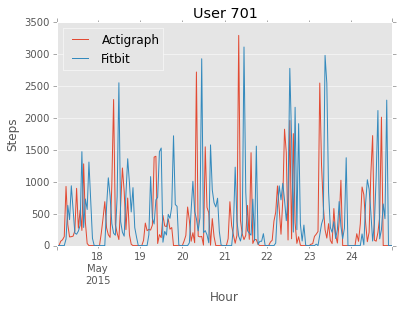

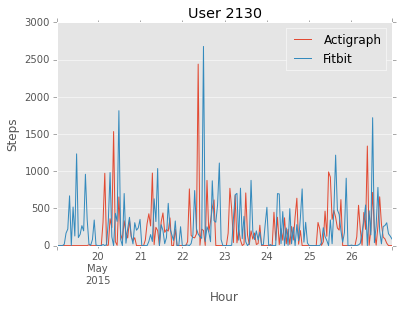

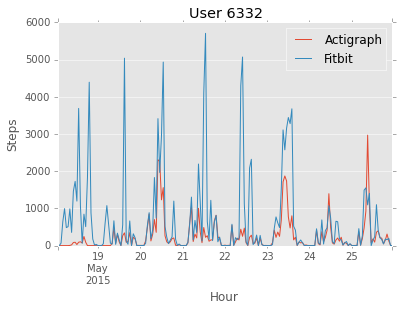

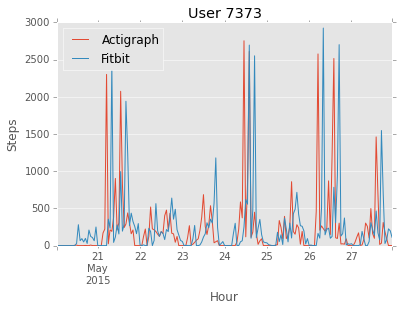

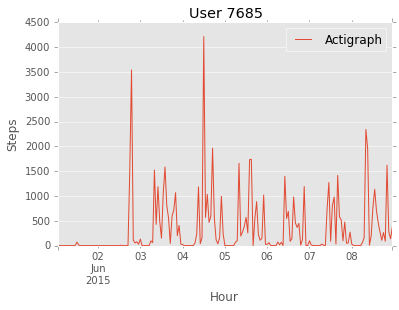

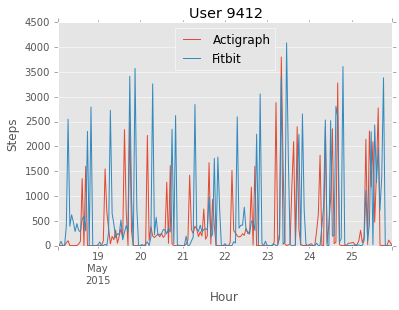

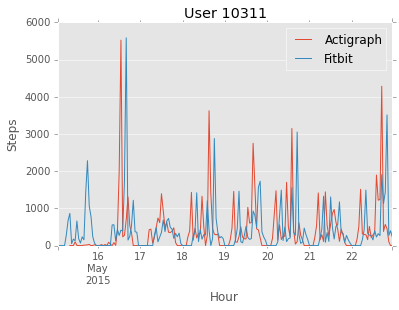

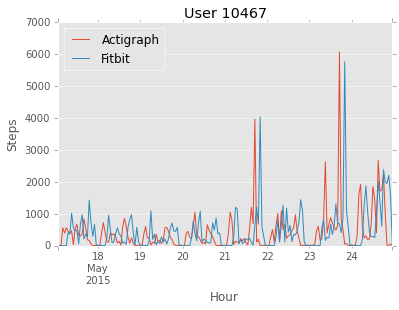

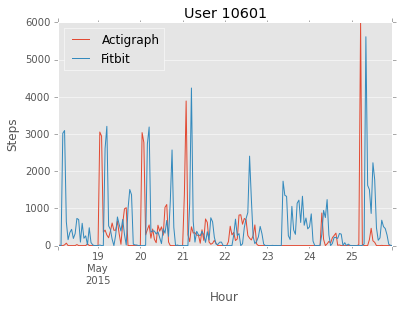

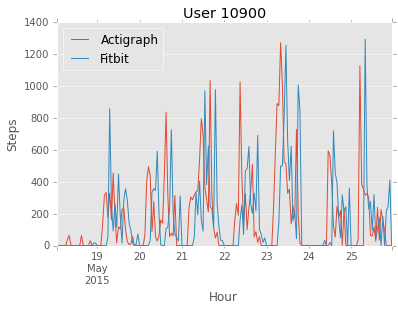

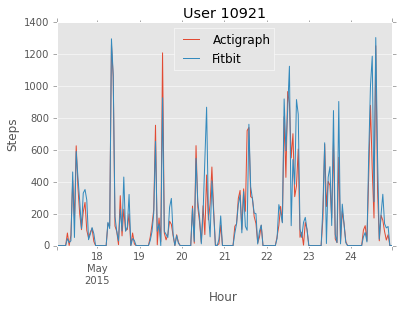

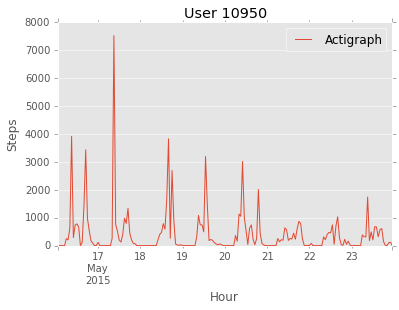

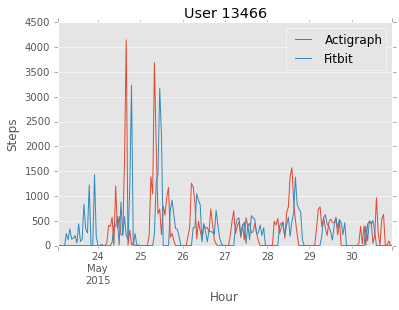

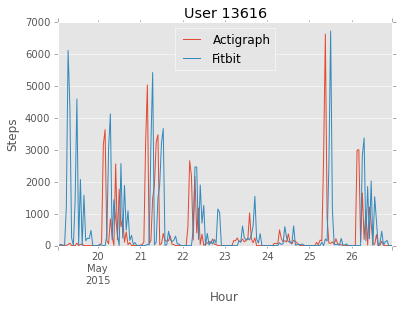

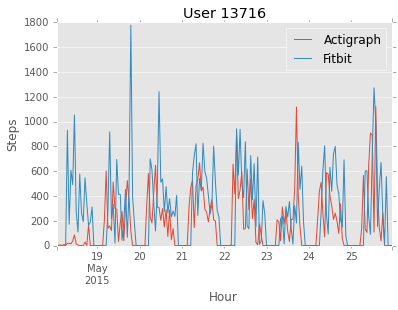

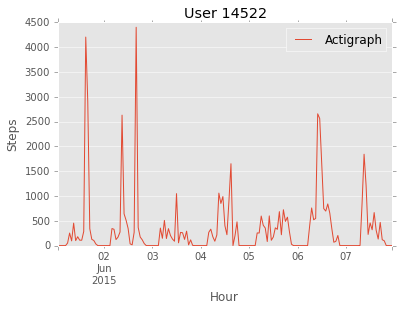

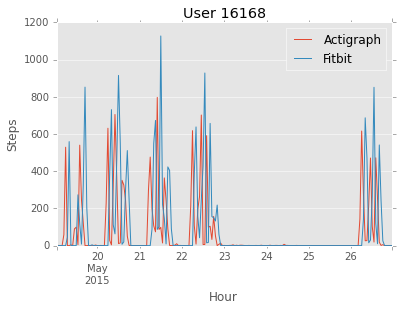

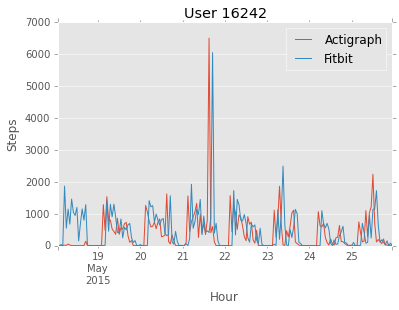

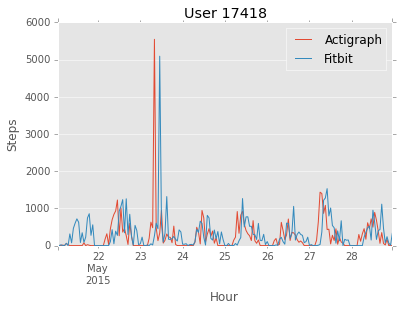

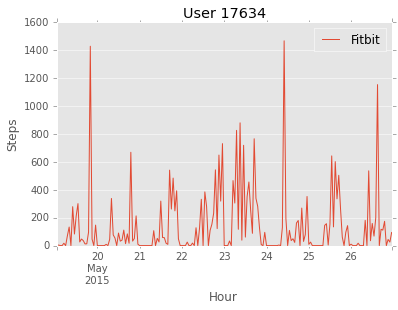

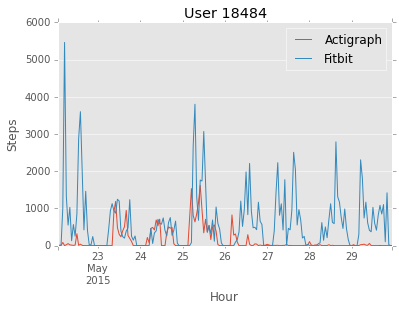

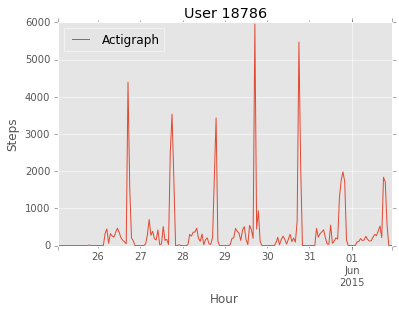

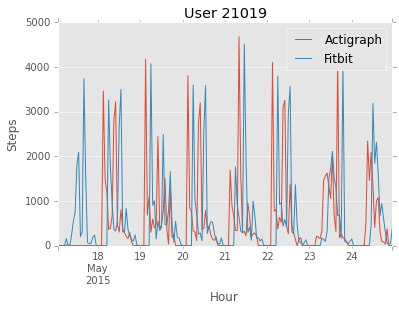

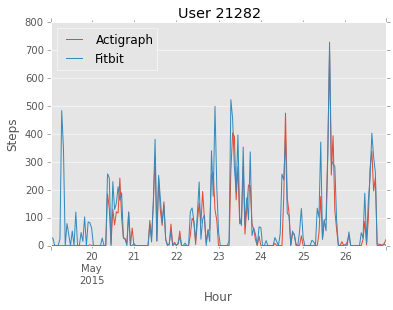

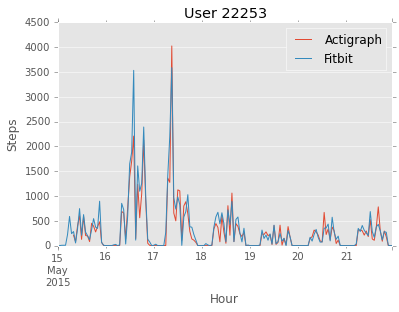

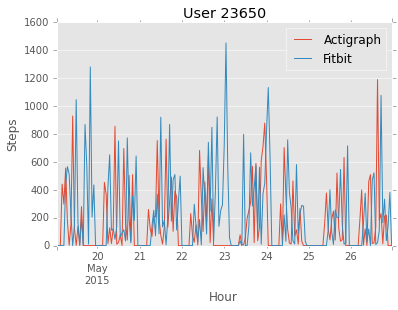

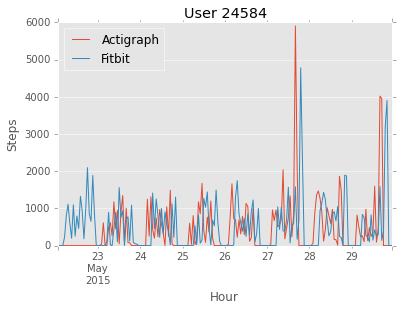

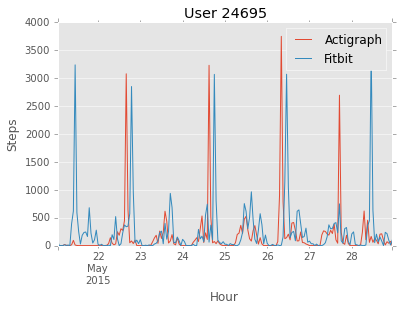

In [128]:
fig = plt.figure()

for user, user_data in master.groupby(['User']):
    fig = plt.figure()
    fig, ax = plt.subplots()
    labels = []
    for key, grp in user_data.groupby(['Type']):
        ax = grp.plot(ax=ax, kind='line', x='Date_Time', y='Steps', c=key)
        labels.append(key)
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.title('User ' + str(user))
    plt.xlabel('Hour')
    plt.ylabel('Steps')

  